<a href="https://colab.research.google.com/github/Sandeep0076/Data-Science/blob/main/Retail_Time_Series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Center> **Retail-Time Series forecasting**

Mounted at /content/Gdrive


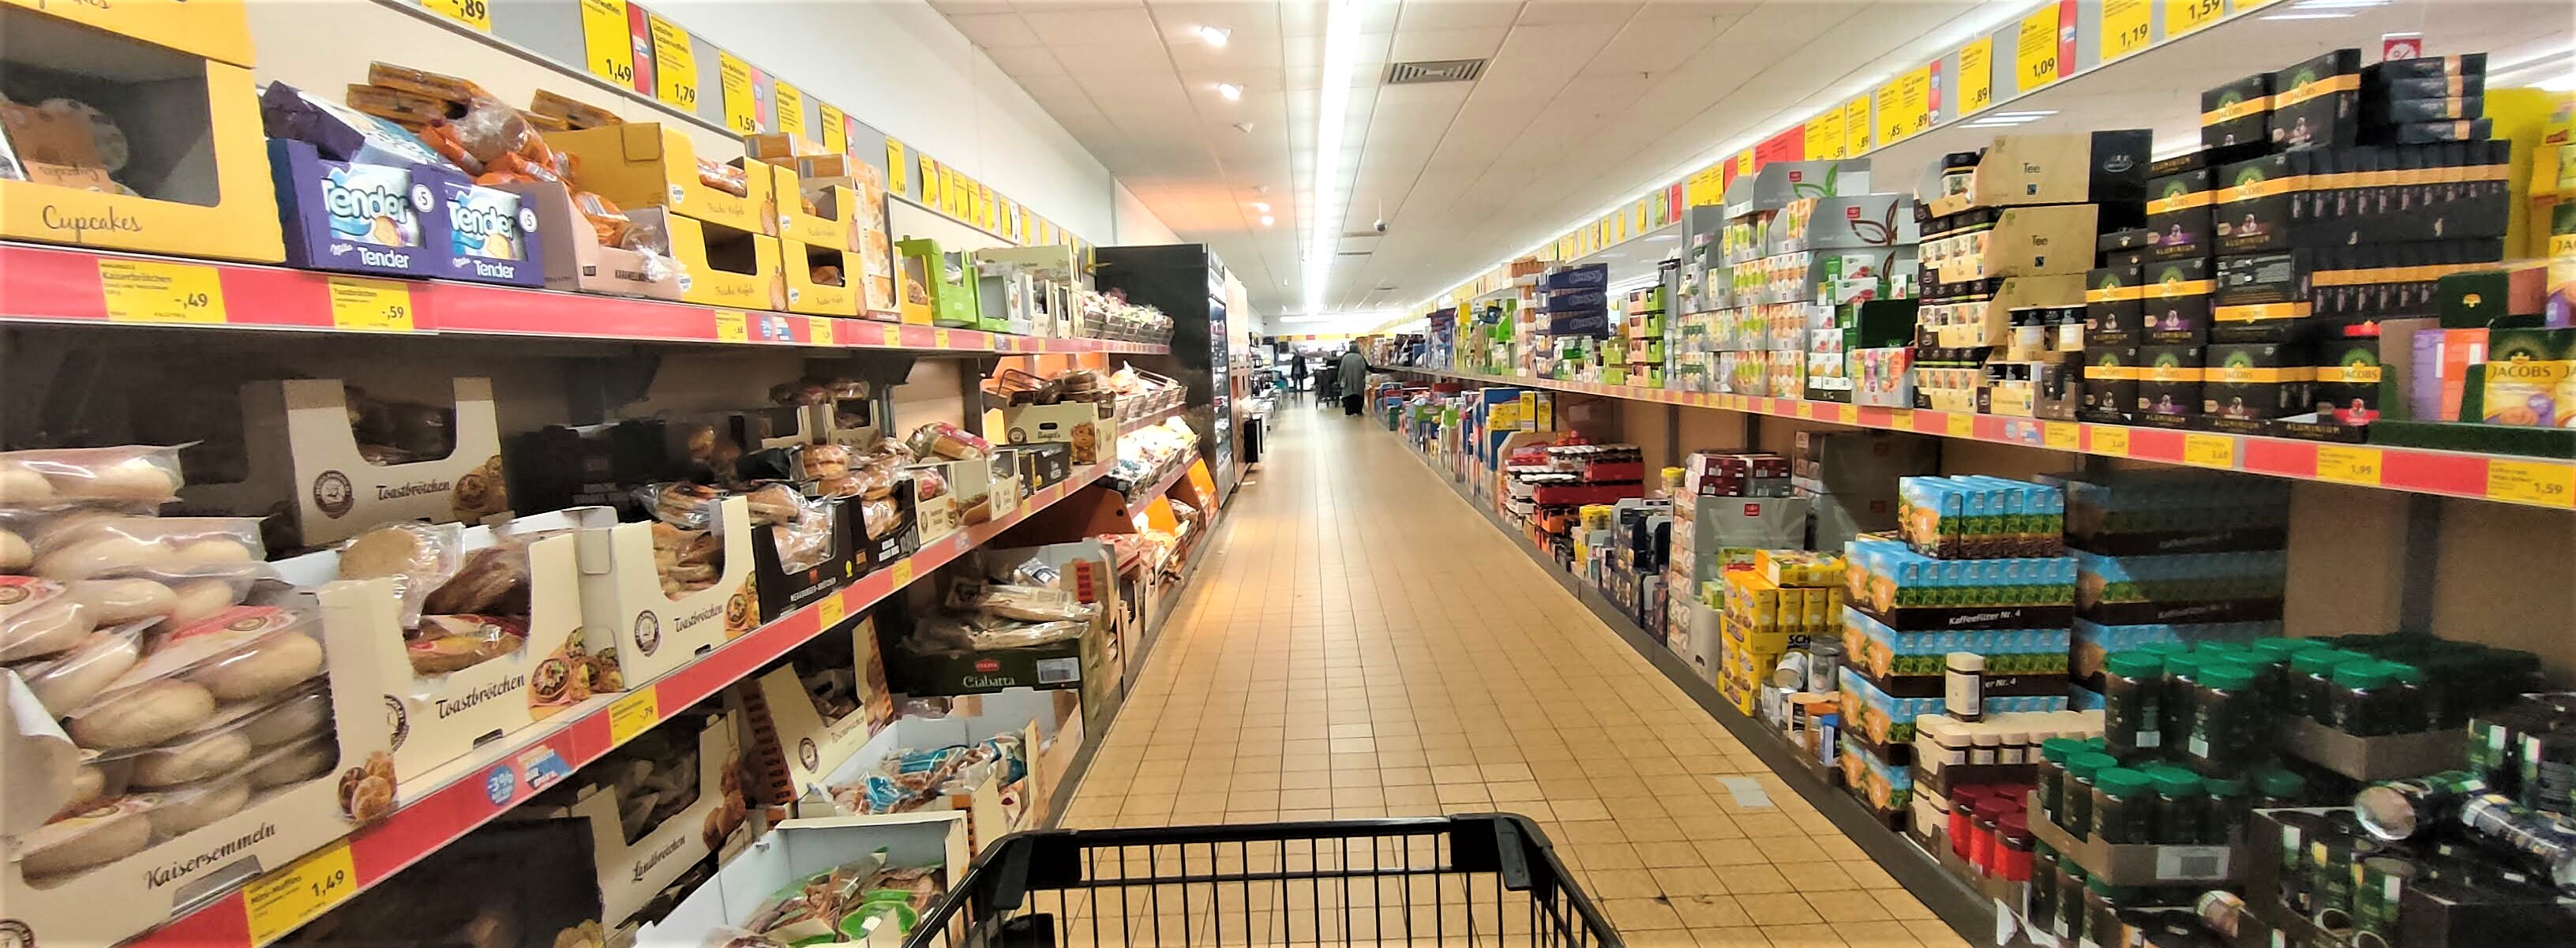

In [1]:
#@title 
from IPython.display import Image
from google.colab import drive
drive.mount("/content/Gdrive")
Image('/content/Gdrive/MyDrive/Data science/retail.jpg', width=2100, height=250)


**Question**

An important goal in retail is to be able to forecast article demand as this enables us to plan our business. This can be done using a basic model that considers the average demand over some weeks in the past. But your product owner wants to know if something better can be done. So she contacts the data engineer who gladly provides a dataset. Now it's your turn to show her what is possible with more advanced models! 

## <Center> **Data Set** 

The data given consists of **weekly sales data for 25 articles** in the category of "Processed Foods" for a certain country for approximately two years. The problem is to **create a demand forecaster** for this category that predicts article-level demand one week in advance. That is, given the features of the current week, the model is able to predict the number of units sold in the following week. You may assume that the unit price, the unit discount and the low stock warning are known for the following week in the current week itself.

In [2]:
#@title Import time series dataset
import pandas as pd
df = pd.read_csv('/content/Gdrive/MyDrive/Data science/take_home_final_data.csv')
df.head()

,art_no,art_name,hierarchy_level1_id,hierarchy_level1_desc,hierarchy_level2_id,hierarchy_level2_desc,hierarchy_level3_id,hierarchy_level3_desc,date_of_day,store_count,sold_qty_units,total_cust_count,low_stock_warning,unit_price_weekly,unit_discount_weekly
0,10,Meat Sauce,100,Processed_Food,3,Broth_Products,4,Soup_Broth_Products,2019-05-16,16,46.0,23,0,0.88,-0.01
1,10,Meat Sauce,100,Processed_Food,3,Broth_Products,4,Soup_Broth_Products,2019-10-10,22,64.0,30,0,0.89,-0.00
2,10,Meat Sauce,100,Processed_Food,3,Broth_Products,4,Soup_Broth_Products,2020-03-26,36,145.0,70,0,0.88,-0.01
3,10,Meat Sauce,100,Processed_Food,3,Broth_Products,4,Soup_Broth_Products,2019-10-17,30,73.0,39,0,0.89,-0.00
4,10,Meat Sauce,100,Processed_Food,3,Broth_Products,4,Soup_Broth_Products,2019-10-31,23,76.0,31,0,0.89,0.00


Explanation of the data columns

* **date_of_day** : The date at the start of the week

* **sold_qty_units** : The number of units sold. **This is the variable that has to be predicted.**

* **art_no** : The article number
* **art_name** : The article name
* **hierarchy_level{}_id** : Product hierachy level id  
* **hierarchy_level{}_desc** : Product hirerachy level description
* **store_count**: The number of stores that offer that article in that week 
* **unit_price_weekly** : The weekly price of one unit of that article for that week (possible discounts already included)
* **unit_discount_weekly** : The Euro value of weekly discount per unit of that sold
* **total_cust_count**: The total number of customers buying that article that week
* **low_stock_warning** : This is binary flag and equals 1 if the stock across a majority of stores is low

In [169]:
#@title Imports 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px 
from pylab import rcParams
import datetime
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')

### <Center> **Sneak peek into the data**

Lets see how the tables look and get some basic information. i.e

1. Data types

2. No of Data (rows and column)

3. Null Data

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2619 entries, 1563 to 2534
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   art_no                 2619 non-null   int64         
 1   art_name               2619 non-null   object        
 2   hierarchy_level1_id    2619 non-null   int64         
 3   hierarchy_level1_desc  2619 non-null   object        
 4   hierarchy_level2_id    2619 non-null   int64         
 5   hierarchy_level2_desc  2619 non-null   object        
 6   hierarchy_level3_id    2619 non-null   int64         
 7   hierarchy_level3_desc  2619 non-null   object        
 8   date_of_day            2619 non-null   object        
 9   store_count            2619 non-null   int64         
 10  sold_qty_units         2619 non-null   float64       
 11  total_cust_count       2619 non-null   int64         
 12  low_stock_warning      2619 non-null   int64         
 13  

Dataset consists of 15 Columns and 2619 rows with no null values. date_of_day column has object datatype, which is needed to be converted and sorted for better understanding of flow of information.

In [244]:
# describing the data
df.describe()

,art_no,hierarchy_level1_id,hierarchy_level2_id,hierarchy_level3_id,store_count,sold_qty_units,total_cust_count,low_stock_warning,unit_price_weekly,unit_discount_weekly
count,2619.000000,2619.0,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000
mean,12.999236,100.0,2.798015,3.001145,32.410462,205.381061,116.203131,0.039710,3.771187,-0.054742
std,7.216768,0.0,1.166464,1.415428,18.042240,499.907577,217.501756,0.195314,3.778304,0.197052
min,1.000000,100.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.450000,-5.460000
25%,7.000000,100.0,2.000000,2.000000,20.000000,37.000000,26.000000,0.000000,1.335000,-0.020000
50%,13.000000,100.0,3.000000,3.000000,32.000000,93.000000,62.000000,0.000000,2.860000,-0.010000
75%,19.000000,100.0,4.000000,4.000000,48.000000,198.500000,124.000000,0.000000,3.990000,-0.000000
max,25.000000,100.0,4.000000,5.000000,75.000000,8902.000000,3050.000000,1.000000,17.040000,0.060000


In [245]:
df.nunique()

art_no                    25
art_name                  25
hierarchy_level1_id        1
hierarchy_level1_desc      1
hierarchy_level2_id        4
hierarchy_level2_desc      4
hierarchy_level3_id        5
hierarchy_level3_desc      5
date_of_day              105
store_count               72
sold_qty_units           592
total_cust_count         422
low_stock_warning          2
unit_price_weekly        368
unit_discount_weekly      91
date                     105
dtype: int64

Looking into the data, I come to the conclusion that, we can analyse the data by grouping data based on the time(weeks, months, years), art_name, hierarchy_level1_desc, hierarchy_level3_desc, unit_discount_weekly, low_stock_warning. But since our focus is forecasting the sales of individual articles sold, I would  focus on individual products. 

### <Center>**Creating new Columns**

In [246]:
# Converting column to datetime pandas
df['date'] = pd.to_datetime(df['date_of_day'], yearfirst=True, infer_datetime_format=True)
df.sort_values(by='date', ascending=True, inplace=True)
df_date = df.copy()

#### Creating 4 new columns: week, month, year, month-year for breaking down the data respectively.

In [247]:
#Calculate week of the month 
def week_number_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
ls = []
for dates in df['date']:
  ls.append(week_number_of_month(dates))

df_date['week'] = ls
#correcting the week numbers
df_date["week"].replace({-49: 4, -50: 3, -48: 5,-51: 2}, inplace=True)

In [248]:
import datetime
# Setting date as index for easy datewise analysis
df_date.set_index('date', inplace=True)
df.sort_values(by='date', ascending=True, inplace=True)

# Creating additional columns for months and year to see the Sales monthy/year wise
df_date['month'] = pd.to_datetime(df_date.index.values).month
df_date['year'] = pd.DatetimeIndex(df_date.index.values).year
df_date["month-year"] = df_date["month"].astype(str) +"-"+ df_date["year"].astype(str)

In [249]:
# I am assuming the negative price means that that much amount will be deducted from the actual price. So if the discount is less than 0 I am making it 1 and if in postive or 0 I am making it 0 indicating no discount 
df_date['discount'] = np.where(df_date.unit_discount_weekly<0, 1, 0)

## <Center>**Analysis**

###  <Center>**Datewise analysis of total products.**

In [250]:
df_datewise = df_date.copy()

In [251]:
#@title Total products sold each month from Feb-2019 till Feb-2021. Can use sliders to see the data in some specific range.

fig = px.bar(df_datewise, x = 'month-year', y = 'sold_qty_units', title = 'Total products sold per month every year', color='month', )
fig.update_xaxes(rangeslider_visible=True)
fig.show()

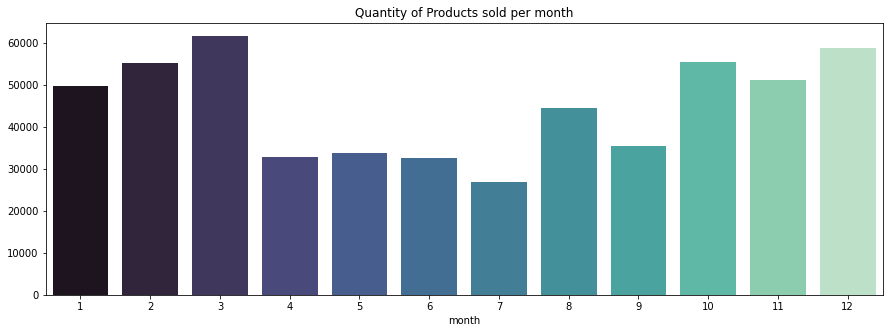

In [252]:
#@title Analysis of total product sold monthwise.
# Which week of the month has maximim sale 
#weekly_report = df_datewise['sold_qty_units'].groupby(df_datewise['month-year']).agg('sum').sort_values(ascending = False)
weekly_report = df_datewise['sold_qty_units'].groupby(df_datewise['month']).agg('sum')
#print(weekly_report)
#plt.figure(figsize=(1,1))
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
sns.barplot(x = weekly_report.index, y = weekly_report.values, palette = 'mako')
plt.title('Quantity of Products sold per month')
plt.show()

From the above graphs we can deduce that the sales of the products are relativels higher at the start and end of the year and lower during the mid of the year.

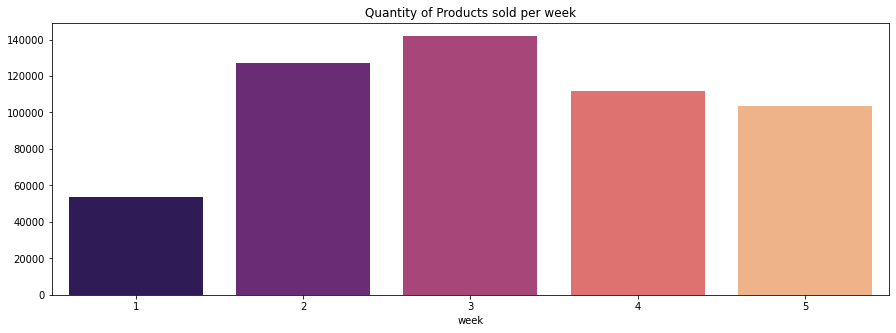

In [253]:
#@title Analysis of total product sold weekwise.
# Which week of the month has maximim sale 
weekly_report = df_datewise['sold_qty_units'].groupby(df_datewise['week']).agg('sum').sort_values(ascending = False)
#print(weekly_report)
sns.barplot(x = weekly_report.index, y = weekly_report.values, palette = 'magma')
plt.title('Quantity of Products sold per week')
plt.show()

There is a very less sale in the first week of the months. Possibly people are waiting for their salary. Then there is a sharp rise in purchase and maximum quantitities of products are sold during middle of the month and then it again declines as month end approaches.



---



### <Center>**Product category wise analysis**

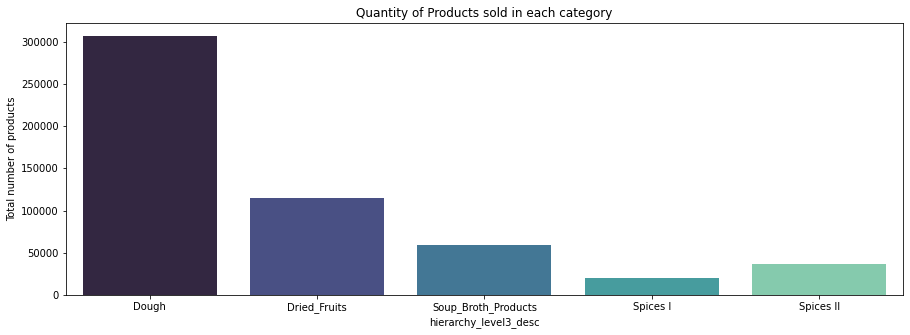

In [32]:
#@title Analysis of category of products(level-3) sold.

weekly_report = df_date['sold_qty_units'].groupby(df_date['hierarchy_level3_desc']).agg('sum')
#print(weekly_report)
#plt.figure(figsize=(1,1))
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
sns.barplot(x = weekly_report.index, y = weekly_report.values, palette = 'mako')
plt.title('Quantity of Products sold in each category')
plt.ylabel('Total number of products')
plt.show()

Over the period of 2 years , The products of Dough category were sold almost 3 time more than the second most sold category Dried_fruits, although the average price of both of the categoies is very close. 

In [33]:
#@title Average price of each category
print(df_date['unit_price_weekly'].groupby(df_date['hierarchy_level3_desc']).agg('mean'))

hierarchy_level3_desc
Dough                  2.072252
Dried_Fruits           2.307886
Soup_Broth_Products    3.884705
Spices I               7.340344
Spices II              3.250345
Name: unit_price_weekly, dtype: float64


#### Products with low stock warnings.

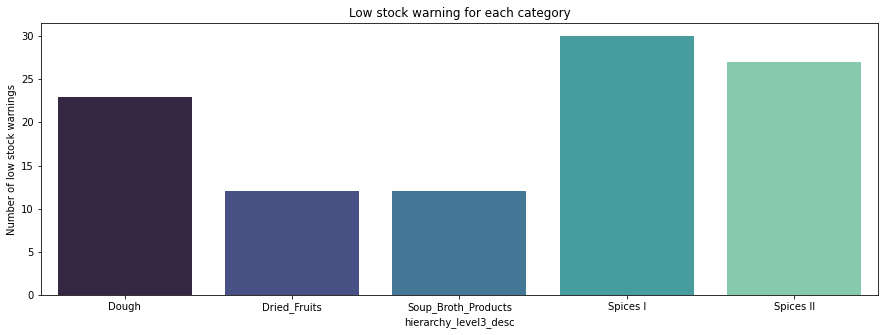

In [34]:
#@title Analysis of category of products with low stock warnings.

low_stock = df_date['low_stock_warning'].groupby(df_date['hierarchy_level3_desc']).agg('sum')
#print(weekly_report)
#plt.figure(figsize=(1,1))
rcParams['figure.figsize'] = 15, 5
sns.barplot(x = low_stock.index, y = low_stock.values, palette = 'mako')
plt.title('Low stock warning for each category')
plt.ylabel('Number of low stock warnings')
plt.show()

Products of category Dough had high demand and hence its reflected in the graph that it has higer low_stock_warnings. In contrast, Products of category 'Spices 1 and 2' had least amount of sale still has high volume of low_stock_warnings.

In [35]:
#@title Amount of products(Level-3) sold per month.
fig = px.bar(df_date, x="month-year", y="sold_qty_units", color='hierarchy_level3_desc')
fig.show()

***Can click on individual product category and toggle on and off other categories for better visualization**

Upon analyzing we can deduce that :


*   Sales of Spice 2 is rising every month with time. 
*   There is a dip in sales of Soup_Broth_Products,Dried_fruits, Dough in mid year and peaks at year end. 
*   Spice 1 was sold more in year 2019 and less in 2020. A decline in sales can be seen. It is noted that, there was highest low_stock warnings for Spice 1 too. 



### <Center>**Individual product wise analysis**

In [36]:
#@title Amount of individual articles sold per month.
fig = px.bar(df_date, x="month-year", y="sold_qty_units", color='art_name')
fig.show()

Observations after analyzing all 25 products indiviually:


*   **Items which were sold in high qunatity only during (Oct-Dec) Year end:**  40g Chilli Pepper, 30g Bio Savoury Spices, 30g Bio Thyme, 80g Bio pepper Whole, 200g Green Pepper.
*   **Items which were sold high during spring(March-May) and year end months:** 500g Pasta Rigate, Fine Mushroom Sauce, Pista Penne, Pasta Penne, 125g dark Chocolate, 200g Chocolate Crumble, 150g Chocolate Coatings, 420g Baling Powder, Spiced Salt for meat, 80g Bio Pepper Whole.


*   A decline in sales of 500g Indian Curry Item is seen. In pevious graphs highest low_stock warnings for this item was showen too. 



*  **There were few items which were sold iregularly or didnt showed any specific trend :**  80g Granulated Onion, 1kg Gnocchi, 500g Speghetti, Pasta Penne
*   In average there was low sale of items were seen during mid of the year and high sales is seen during the year end.








### <Center> **Correlation**

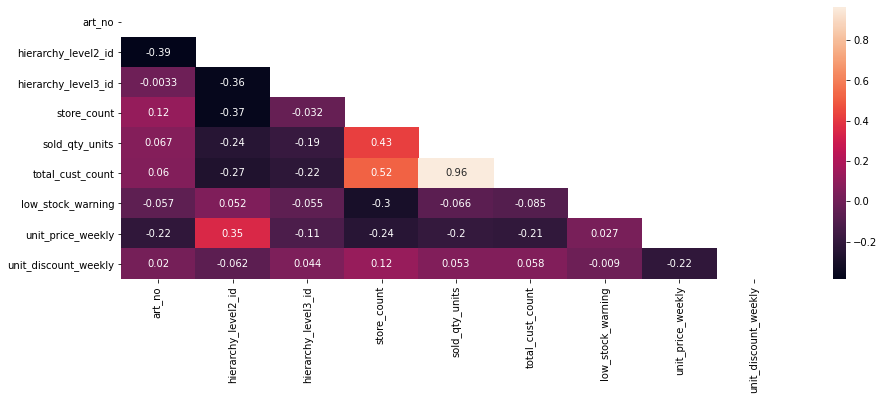

In [37]:
#@title Correlation between different variables of dataset
df_corr = df_date.copy()
df_corr = df.drop(columns=['hierarchy_level1_id'])
corr= df_corr.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

Understandably, there is a strong corelation between total customer count and total amount of product sold. Also Total store count is postively corelated to amount of product sold. More the number of products in different stores, more is the sale. 



---



*I will try some models on one of the product dataset to check which model performs the best. Once model is decided, I will loop through complete dataset and forcast the total items sold next week for each item.*

##<Center> **LSTM Birectional Forecasting Model**

In [38]:
'''!pip install gdown
!pip install tensorflow.gpu'''

'!pip install gdown\n!pip install tensorflow.gpu'

#### Preprocessing

In [238]:
df_Green_Pepper = df_date[df_date.art_name == '200g Green Pepper']
last_date = df_Green_Pepper.date_of_day[-1]
df_Green_Pepper = df_Green_Pepper[['store_count','sold_qty_units','total_cust_count','week','month']]
# I was getting high loss, so after checking corelation and feature selection, I selected above features and got decent result. 

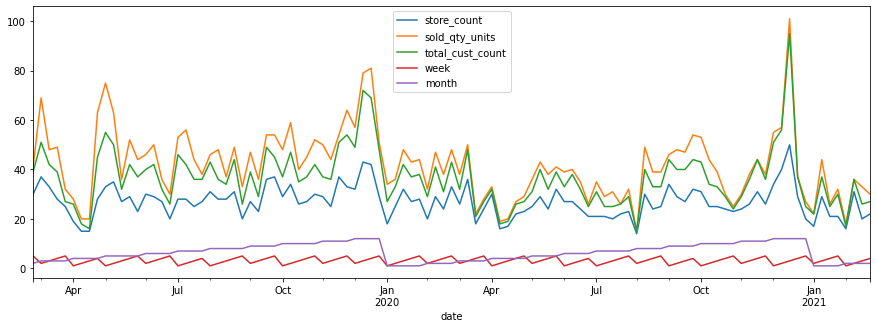

In [239]:
rcParams['figure.figsize'] = 15, 5
df_Green_Pepper.plot()

In [42]:
# Dividing the data into  train, test
train_size = int(len(df_Green_Pepper)*.8)
test_size = len(df_Green_Pepper) - train_size
train,test = df_Green_Pepper.iloc[0:train_size], df_Green_Pepper.iloc[train_size:len(df_Green_Pepper)]
print(train.shape, test.shape)

(84, 5) (21, 5)


In [43]:
#@title # Feature scaling
# Feature scaling
colms = ['store_count','sold_qty_units','total_cust_count','week','month']
scaler_var = StandardScaler()
scaler_cnt = StandardScaler()
#scaler_test = StandardScaler()

scaler_var = scaler_var.fit(train.loc[:,colms])
scaler_cnt = scaler_cnt.fit(train[['sold_qty_units']])


train.loc[:,colms] = scaler_var.transform(train.loc[:,colms])
train['sold_qty_units'] = scaler_cnt.transform(train[['sold_qty_units']])

#scaler_test = scaler_test.fit(test[['sold_qty_units']])
test.loc[:,colms] = scaler_var.transform(test.loc[:,colms])
test['sold_qty_units'] = scaler_cnt.transform(test[['sold_qty_units']])


In [44]:
# Creating a function to extract y values(target) values from the previous n values 
#######################################################################################################################################
#### Lets say from last 4 week values and want to predict the 5th value, so we can create a dataset in such a way that          #######
#### first 4 values with be the training dataset and 5th value would be the target  value                                       #######
#######################################################################################################################################
from keras import optimizers
def create_dataset(X, y, time_steps=1):
  Xs, ys = [],[]
  for i in range(len(X)-time_steps):
    val = X.iloc[i: (i+time_steps)].to_numpy()
    Xs.append(val)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

time_steps=1

x_train, y_train = create_dataset(train, train.sold_qty_units,time_steps = time_steps)
x_test, y_test = create_dataset(test, test.sold_qty_units, time_steps = time_steps)

# [Samples, Time-steps, n_features]
print(f'Shape of training data:  {x_train.shape}  and target variable: {y_train.shape}')

model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True)))
model.add(keras.layers.LSTM(64,activation='relu',return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

#sgd = optimizers.SGD(lr=0.01)
adm = optimizers.Adam(lr=0.0001)

model.compile(loss='mean_squared_error',optimizer=adm)

history = model.fit(
    x_train,y_train,
    epochs=40,
    batch_size=2,
    validation_split=0.1,
    shuffle=False
)

Shape of training data:  (83, 1, 5)  and target variable: (83,)
Epoch 1/40
37/37 [==============================] - 5s 38ms/step - loss: 10.4599 - val_loss: 10.2150
Epoch 2/40
37/37 [==============================] - 0s 4ms/step - loss: 10.0263 - val_loss: 9.7366
Epoch 3/40
37/37 [==============================] - 0s 4ms/step - loss: 9.4437 - val_loss: 9.0657
Epoch 4/40
37/37 [==============================] - 0s 5ms/step - loss: 8.6747 - val_loss: 8.1356
Epoch 5/40
37/37 [==============================] - 0s 4ms/step - loss: 7.5072 - val_loss: 6.8361
Epoch 6/40
37/37 [==============================] - 0s 4ms/step - loss: 5.9899 - val_loss: 5.1151
Epoch 7/40
37/37 [==============================] - 0s 4ms/step - loss: 4.0817 - val_loss: 3.0918
Epoch 8/40
37/37 [==============================] - 0s 4ms/step - loss: 2.2191 - val_loss: 1.2835
Epoch 9/40
37/37 [==============================] - 0s 4ms/step - loss: 0.7518 - val_loss: 0.2899
Epoch 10/40
37/37 [==============================]

#### Evaluation

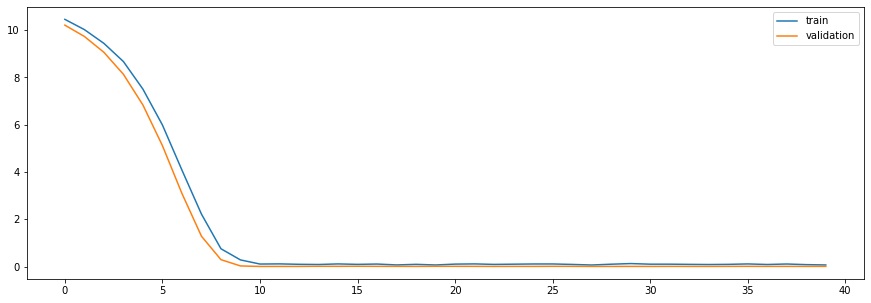

In [45]:
#@title Loss curve
rcParams['figure.figsize'] = 15, 5
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

In [46]:
# Predicting test data 
y_test_pred = model.predict(x_test)
# Scaling back test data 
y_test_inv = scaler_cnt.inverse_transform(y_test.reshape(1,-1))
y_test_pred_inv= scaler_cnt.inverse_transform(y_test_pred.reshape(1,-1))
Predicted_test_data = scaler_cnt.inverse_transform(y_test_pred_inv)
Actual_test_data = scaler_cnt.inverse_transform(y_test_inv)

In [47]:
#@title Calculate RMSE performance metrics for test data 
### Calculating Root mean square error


print(f'Root mean square error of test data is : {math.sqrt(mean_squared_error(Actual_test_data,Predicted_test_data))}')

Root mean square error of test data is : 24.151603519379382


In [48]:
# Predicting train data 
x_train_pred = model.predict(x_train)
# Scaling back
x_train_pred_inv = scaler_cnt.inverse_transform(x_train_pred.reshape(1,-1))
y_train_inv = scaler_cnt.inverse_transform(y_train.reshape(1,-1))
Predicted_train_data = scaler_cnt.inverse_transform(x_train_pred_inv)
Actual_train_data = scaler_cnt.inverse_transform(y_train_inv)

In [49]:
#@title Calculate RMSE performance metrics for training data 
### Calculate RMSE performance metrics for training data 


print(f'Root mean square error of Training dataset is : {math.sqrt(mean_squared_error(Actual_train_data,Predicted_train_data))}')

Root mean square error of Training dataset is : 14.043534057527182


#### Future prediction

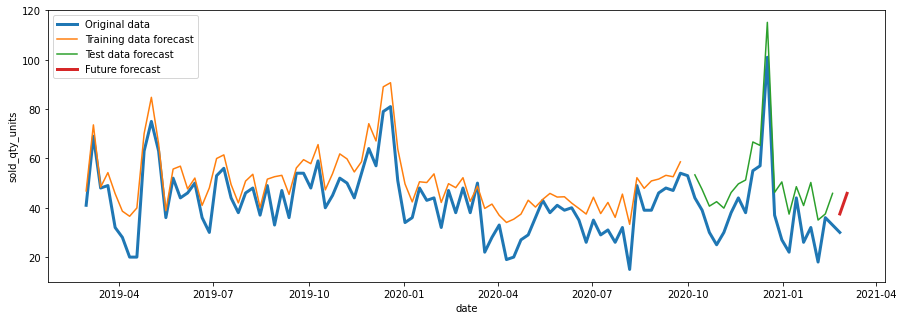

In [50]:
#@title Plotting orignal dataset with forecasted date
# Creating future dates for prediction
n_future = 2
forecast_dates = pd.date_range(last_date,periods=n_future,freq='7d').tolist()

# Forcasting the quantity
forecast = model.predict(x_test[-n_future:])
inv = scaler_cnt.inverse_transform(forecast)
forecast_scaled = scaler_cnt.inverse_transform(inv)
df_forecast = pd.DataFrame({'date':forecast_dates, 'sold_qty_units':forecast_scaled.flatten()} )
df_forecast['date'] = pd.to_datetime(df_forecast['date'])
# Plotting the forcast with the orignal data
orig = df_date.loc[df_date.art_name == '200g Green Pepper', "sold_qty_units"]
orig= orig.to_frame()
orig = orig.reset_index()
df_forecast = pd.DataFrame({'date':forecast_dates, 'sold_qty_units':forecast_scaled.flatten()} )
df_forecast['date'] = pd.to_datetime(df_forecast['date'])
sns.lineplot(orig['date'],orig['sold_qty_units'], label ='Original data',linewidth = 3)
sns.lineplot(train.index.values[:-1,],Predicted_train_data.flatten(), label ='Training data forecast')
#sns.lineplot(df_test['date'],df_test['sold_qty_units'], label ='Test data forecast')
sns.lineplot(test.index.values[:-1,],Predicted_test_data.flatten(), label ='Test data forecast')
sns.lineplot(df_forecast['date'],df_forecast['sold_qty_units'],label ='Future forecast', linewidth = 3)

In [51]:
#@title NEXT WEEK
print(f'It is predicted that next week {round(forecast_scaled.flatten()[1])} items would be sold')
print(f'Total quantity sold for this item in last three weeks are {Actual_test_data.flatten()[-3:]}')

It is predicted that next week 46 items would be sold
Total quantity sold for this item in last three weeks are [36. 33. 30.]




---



##<Center> **Prophet-multivariate**

In [114]:
# Preparing dataset for the profet model as it takes input value in particul convention
df_prophet_m = df_date[df_date.art_name == '200g Green Pepper']
df_prophet_m = df_prophet_m.reset_index()[['date','store_count','sold_qty_units','low_stock_warning','week','month','discount','total_cust_count']].rename({'date':'ds','sold_qty_units':'y','store_count':'store_count','low_stock_warning':'low_stock_warning','week':'week','month':'month','discount':'discount','total_cust_count':'total_cust_count'},axis='columns')

In [115]:
df_prophet_m.tail(2)

,ds,store_count,y,low_stock_warning,week,month,discount,total_cust_count
103,2021-02-18,20,33.0,0,3,2,1,26
104,2021-02-25,22,30.0,0,4,2,0,27


In [116]:
# Dividing the data into train and test set so that when prediction, it need values of other columns kuje week, month, store count etc, so we can add those information
#from the test dataset
start = '2019-02-28'
end =  '2020-10-01'
train_prophet = df_prophet_m[(df_prophet_m['ds']>=start) & (df_prophet_m['ds']<=end)]
test_prophet = df_prophet_m[(df_prophet_m['ds']>end)]

In [117]:
# Initializing 
model_prophet_m = Prophet()
# By defaul, prophet just takes 2 columns. As it is an additive linear model by default. I am adding these columns as additional regressors
model_prophet_m.add_regressor('store_count',standardize='auto',mode='multiplicative')
model_prophet_m.add_regressor('low_stock_warning')
model_prophet_m.add_regressor('total_cust_count',standardize='auto',mode='multiplicative')
model_prophet_m.add_regressor('discount')
model_prophet_m.add_regressor('week',standardize='auto')
model_prophet_m.add_regressor('month',standardize='auto')
model_prophet_m.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
# adding values of the last week for future forecast
def get_lastinput(): 
  ls = [] 
  future_dates_m = model_prophet_m.make_future_dataframe(periods=(len(test_prophet)+1),freq='W-THU')
  ls.append(future_dates_m['ds'].iloc[-1])
  ls.append(test_prophet['store_count'].iloc[-1])
  ls.append(test_prophet['y'].iloc[-1])
  ls.append(test_prophet['low_stock_warning'].iloc[-1])
  ls.append(week_number_of_month(future_dates_m['ds'].iloc[-1]))
  ls.append(future_dates_m['ds'].iloc[-1].month)
  ls.append(test_prophet['discount'].iloc[-1])
  ls.append(test_prophet['total_cust_count'].iloc[-1])

  return ls
  
df_length = len(test_prophet)
test_prophet.loc[df_length] = get_lastinput()
test_prophet = test_prophet.reset_index(drop=True)

In [120]:
test_prophet_m = test_prophet.drop(columns='y')
forecast_prophet_m = model_prophet_m.predict(test_prophet_m)

In [121]:
forecast_prophet_m.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,discount,discount_lower,discount_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,low_stock_warning,low_stock_warning_lower,low_stock_warning_upper,month,month_lower,month_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,store_count,store_count_lower,store_count_upper,total_cust_count,total_cust_count_lower,total_cust_count_upper,week,week_lower,week_upper,yhat
17,2021-02-04,42.660422,16.395582,23.967769,42.486306,42.854986,0.641426,0.641426,0.641426,0.09017,0.09017,0.09017,0.641426,0.641426,0.641426,-0.549764,-0.549764,-0.549764,0.0,0.0,0.0,-0.209136,-0.209136,-0.209136,-0.549764,-0.549764,-0.549764,0.070763,0.070763,0.070763,-0.620527,-0.620527,-0.620527,0.760392,0.760392,0.760392,19.848693
18,2021-02-11,42.694712,37.497491,44.699637,42.501360,42.906585,0.282589,0.282589,0.282589,0.09017,0.09017,0.09017,0.282589,0.282589,0.282589,-0.048263,-0.048263,-0.048263,0.0,0.0,0.0,-0.209136,-0.209136,-0.209136,-0.048263,-0.048263,-0.048263,-0.024699,-0.024699,-0.024699,-0.023564,-0.023564,-0.023564,0.401555,0.401555,0.401555,40.916716
19,2021-02-18,42.729003,26.553973,33.717655,42.521193,42.955747,-0.076247,-0.076247,-0.076247,0.09017,0.09017,0.09017,-0.076247,-0.076247,-0.076247,-0.292449,-0.292449,-0.292449,0.0,0.0,0.0,-0.209136,-0.209136,-0.209136,-0.292449,-0.292449,-0.292449,0.045307,0.045307,0.045307,-0.337755,-0.337755,-0.337755,0.042719,0.042719,0.042719,30.156720
20,2021-02-25,42.763293,26.773960,34.306230,42.538406,43.016102,-0.525254,-0.525254,-0.525254,0.00000,0.00000,0.00000,-0.525254,-0.525254,-0.525254,-0.273758,-0.273758,-0.273758,0.0,0.0,0.0,-0.209136,-0.209136,-0.209136,-0.273758,-0.273758,-0.273758,0.032578,0.032578,0.032578,-0.306336,-0.306336,-0.306336,-0.316118,-0.316118,-0.316118,30.531256
21,2021-03-04,42.797583,27.788448,35.543757,42.558214,43.073059,0.600190,0.600190,0.600190,0.00000,0.00000,0.00000,0.600190,0.600190,0.600190,-0.273758,-0.273758,-0.273758,0.0,0.0,0.0,-0.160201,-0.160201,-0.160201,-0.273758,-0.273758,-0.273758,0.032578,0.032578,0.032578,-0.306336,-0.306336,-0.306336,0.760392,0.760392,0.760392,31.681603


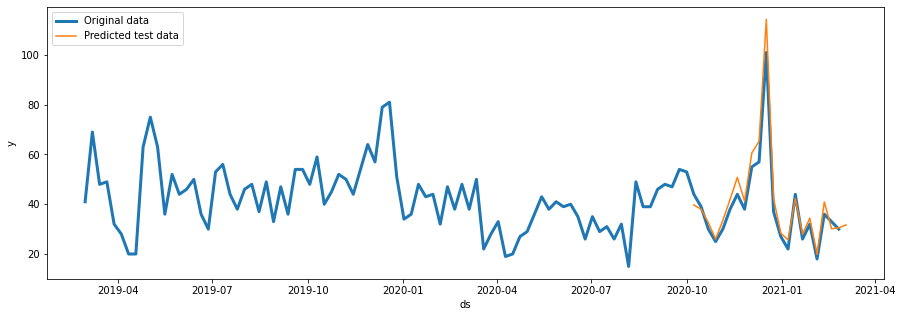

In [122]:
#@title Plotting the forecasted values against actual values
# Plotting the prophet model forecast
rcParams['figure.figsize'] = 15, 5
sns.lineplot(df_prophet_m['ds'],df_prophet_m['y'], label ='Original data',linewidth = 3)
sns.lineplot(forecast_prophet_m['ds'],forecast_prophet_m['yhat'], label ='Predicted test data')

Blue line goes through the predicted values. Black dots are the actual values over the time spam. Light blue area is the upper and lower limit(confidence) of the forecast.

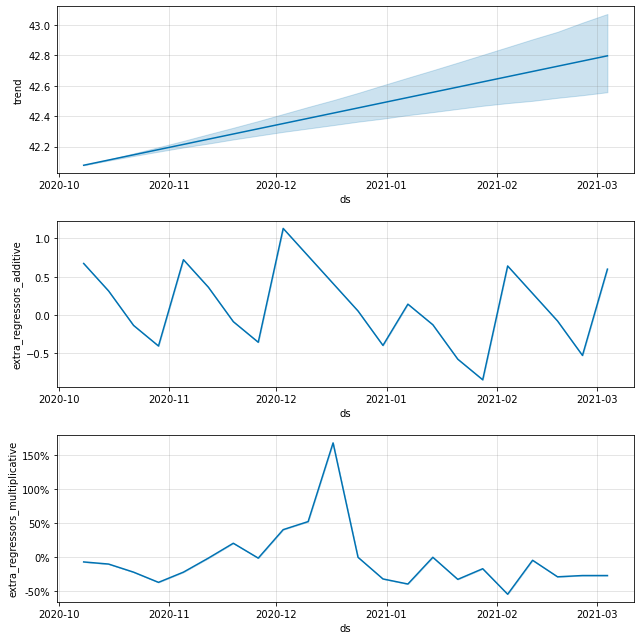

In [123]:
#@title Trend
model_prophet_m.plot_components(forecast_prophet_m);

Trend for just the test data shows that over the period of time , the quantity sold is increasing  but with greater variance. Additive regressors shows that sales are high normally during mid of the months and less at the start of the monmths. Multiplicative regressors indicates that there is huge surge in sales in year end and for rest of the year its normal 

#### Evaluation

In [124]:
df_cv_m = cross_validation(model_prophet_m,initial='465 days',period='7 days', horizon='14 days'  )

INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


In [125]:
# checking the last 5 values of the pedicted values(yhat) against the actual values(y)
df_cv_m.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
25,2020-09-17,44.375756,40.532232,47.766485,47.0,2020-09-03
26,2020-09-17,44.971684,40.938162,49.072573,47.0,2020-09-10
27,2020-09-24,48.365185,44.535380,52.003747,54.0,2020-09-10
28,2020-09-24,48.659895,44.637055,52.168566,54.0,2020-09-17
29,2020-10-01,48.757896,44.942679,52.649237,53.0,2020-09-17


In [126]:
# Checking the performance of the model
from fbprophet.diagnostics import performance_metrics
df_p_m = performance_metrics(df_cv_m)
df_p_m

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,10.208972,3.195148,2.620216,0.069745,0.070136,0.800000
1,14 days,11.604905,3.406597,2.907619,0.074726,0.062940,0.666667


In [127]:
#@title Calculate RMSE performance metrics for training data
error = df_p_m['rmse'].iloc[-1]
print(f'The root mean square error for the dataset is : {error} ')

The root mean square error for the dataset is : 3.4065973354169974 


In [128]:
#@title Calculate RMSE performance metrics for test data 
### Calculate RMSE performance metrics for test data 


print(f'Root mean square error of test dataset is : {math.sqrt(mean_squared_error(test_prophet.y,forecast_prophet_m.yhat))}')

Root mean square error of test dataset is : 4.690431965129663


In [129]:
#@title Next week prediction
sold_item = forecast_prophet_m['yhat'].iloc[-1]
print(f'It is predicted that next week {round(sold_item)} items would be sold')
print(f'Total quantity sold for this item in last three weeks are {df_prophet_m.y[-3:].values}')

It is predicted that next week 32 items would be sold
Total quantity sold for this item in last three weeks are [36. 33. 30.]




---



##<Center> **XGBoost**

In [125]:
# Preparing dataset for the xboost 
df_xgboost = df_date[df_date.art_name == '200g Green Pepper']
last_date = df_xgboost.date_of_day[-1]
df_xgboost = df_xgboost.assign(label=df_xgboost.sold_qty_units.shift(-1)).fillna({'label': df_xgboost['sold_qty_units'].tail(1)})
df_xgboost = df_xgboost[['store_count','total_cust_count','week','month','low_stock_warning','discount','label']]

In [126]:
# Dividing the data into  train, test
end =  '2020-10-01'
start =  '2020-10-08'
train_xgboost =df_xgboost[:end]
test_xgboost = df_xgboost[start:]

In [127]:
# Adding last date and other parameters needed for forecasting final output
forecast_dates = pd.date_range(last_date,periods=2,freq='7d').tolist()[1]
def get_lastinput(): 
  ls = [] 
  ls.append(test_xgboost['store_count'].iloc[-1])
  ls.append(test_xgboost['total_cust_count'].iloc[-1])
  ls.append(week_number_of_month(forecast_dates))
  ls.append(pd.to_datetime(forecast_dates).month)
  ls.append(test_xgboost['low_stock_warning'].iloc[-1])
  ls.append(test_xgboost['discount'].iloc[-1])
  ls.append(test_xgboost['label'].iloc[-1])
  return ls
  
df_length = len(test_xgboost)
test_xgboost.loc[df_length] = get_lastinput()
#adjusting index of last added forecast date
as_list = test_xgboost.index.tolist()
idx = as_list.index(21)
as_list[idx] = forecast_dates
test_xgboost.index = as_list

#dividing into input and target variables
x_train = train_xgboost.drop('label', axis=1)
y_train = train_xgboost['label']
x_test = test_xgboost.drop('label', axis=1)
y_test = test_xgboost['label']


In [128]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators = 300, learning_rate = 0.01)
model_xgb.fit(x_train,y_train,
              eval_set=[(x_train,y_train),(x_test,y_test)],
              eval_metric='rmse')

[20:14:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:43.9297	validation_1-rmse:40.1096
[1]	validation_0-rmse:43.5311	validation_1-rmse:39.7402
[2]	validation_0-rmse:43.1367	validation_1-rmse:39.3751
[3]	validation_0-rmse:42.7465	validation_1-rmse:39.0141
[4]	validation_0-rmse:42.3603	validation_1-rmse:38.6572
[5]	validation_0-rmse:41.9782	validation_1-rmse:38.3044
[6]	validation_0-rmse:41.6002	validation_1-rmse:37.9557
[7]	validation_0-rmse:41.2261	validation_1-rmse:37.611
[8]	validation_0-rmse:40.856	validation_1-rmse:37.2703
[9]	validation_0-rmse:40.4898	validation_1-rmse:36.9336
[10]	validation_0-rmse:40.1275	validation_1-rmse:36.6007
[11]	validation_0-rmse:39.769	validation_1-rmse:36.2718
[12]	validation_0-rmse:39.4143	validation_1-rmse:35.9467
[13]	validation_0-rmse:39.0634	validation_1-rmse:35.6254
[14]	validation_0-rmse:38.7163	validation_1-rmse:35.3079
[15]	validation_0-rmse:38.3728	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### Forecasting

In [129]:
forecast_xgb = model_xgb.predict(x_test)
#adding forecasted value to dataframe for plotting
test_xgboost = test_xgboost.reset_index()
test_xgboost['pred'] = pd.Series(forecast_xgb)

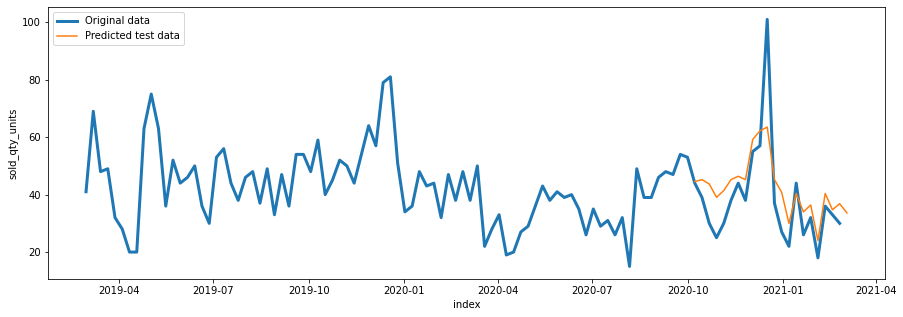

In [130]:
#@title Plotting the forecasted values against actual values
# Plotting the prophet model forecast
temp_df = df_date[df_date.art_name == '200g Green Pepper']
rcParams['figure.figsize'] = 15, 5
sns.lineplot(temp_df.index.values,temp_df['sold_qty_units'], label ='Original data',linewidth = 3)
sns.lineplot(test_xgboost['index'],test_xgboost['pred'], label ='Predicted test data')

In [131]:
#@title Calculate RMSE performance metrics for test data 
### Calculate RMSE performance metrics for test data 


print(f'Root mean square error of test dataset is : {math.sqrt(mean_squared_error(y_test,test_xgboost.pred))}')

Root mean square error of test dataset is : 14.768442370197556


In [132]:
#@title Next week prediction
temp_df = df_date[df_date.art_name == '200g Green Pepper']
sold_item =test_xgboost['pred'].iloc[-1]
print(f'It is predicted that next week {round(sold_item)} items would be sold')
print(f'Total quantity sold for this item in last three weeks are {temp_df.sold_qty_units[-3:].values}')

It is predicted that next week 34 items would be sold
Total quantity sold for this item in last three weeks are [36. 33. 30.]




---



## <center >**Comparing models**

Of all the models Prophet model outperformed all the models with significant difference. 

Root mean square error of test data of respective models are :



1.   Prophet : 4.69
2.   XGBoost : 14.76
3.   Stacked LSTM : 24.15





I will now create run Prophet model and loop through all the product items to get the predictions

## <Center>**Prophet model** -for all product items

In [220]:
products = df_datewise.art_name.unique()
#products_temp = products[:2]
# Dataframe for storing prediction of each item 
df_result = pd.DataFrame()

# Dataframe for storing information of actual and predicted values for later crosscheck
df_predictions = pd.DataFrame()

In [221]:
for item in products:

  result = {}
  result['item'] = item
  # Preparing dataset for the profet model as it takes input value in particul convention
  df_prophet_m = df_date[df_date.art_name == item]
  df_prophet_m = df_prophet_m.reset_index()[['date','store_count','sold_qty_units','low_stock_warning','week','month','discount','total_cust_count']].rename({'date':'ds','sold_qty_units':'y','store_count':'store_count','low_stock_warning':'low_stock_warning','week':'week','month':'month','discount':'discount','total_cust_count':'total_cust_count'},axis='columns')
  # Dividing the data into train and test set so that when prediction, it need values of other columns kuje week, month, store count etc, so we can add those information
  #from the test dataset
  start = '2019-02-28'
  end =  '2020-10-01'
  train_prophet = df_prophet_m[(df_prophet_m['ds']>=start) & (df_prophet_m['ds']<=end)]
  test_prophet = df_prophet_m[(df_prophet_m['ds']>end)]
  # Initializing 
  model_prophet_m = Prophet()
  # By defaul, prophet just takes 2 columns. As it is an additive linear model by default. I am adding these columns as additional regressors
  model_prophet_m.add_regressor('store_count',standardize='auto',mode='multiplicative')
  model_prophet_m.add_regressor('low_stock_warning')
  model_prophet_m.add_regressor('total_cust_count',standardize='auto',mode='multiplicative')
  model_prophet_m.add_regressor('discount')
  model_prophet_m.add_regressor('week',standardize='auto')
  model_prophet_m.add_regressor('month',standardize='auto')
  model_prophet_m.fit(train_prophet)
  # adding values of the last week for future forecast
  def get_lastinput(): 
    ls = [] 
    future_dates_m = model_prophet_m.make_future_dataframe(periods=(len(test_prophet)+1),freq='W-THU')
    ls.append(future_dates_m['ds'].iloc[-1])
    ls.append(test_prophet['store_count'].iloc[-1])
    ls.append(test_prophet['y'].iloc[-1])
    ls.append(test_prophet['low_stock_warning'].iloc[-1])
    ls.append(week_number_of_month(future_dates_m['ds'].iloc[-1]))
    ls.append(future_dates_m['ds'].iloc[-1].month)
    ls.append(test_prophet['discount'].iloc[-1])
    ls.append(test_prophet['total_cust_count'].iloc[-1])
    return ls
    
  df_length = len(test_prophet)
  test_prophet.loc[df_length] = get_lastinput()
  test_prophet = test_prophet.reset_index(drop=True)
  test_prophet_m = test_prophet.drop(columns='y')
  forecast_prophet_m = model_prophet_m.predict(test_prophet_m)
  #storing information for later use
  df_predictions[str(item)+'_dt'] = forecast_prophet_m['ds']
  df_predictions[str(item)+'_act'] = test_prophet['y'].values.tolist()
  df_predictions[str(item)+'_pred'] = forecast_prophet_m['yhat'].values.tolist()

  #model_prophet_m.plot_components(forecast_prophet_m);
  # Evaluation
  df_cv_m = cross_validation(model_prophet_m,initial='465 days',period='7 days', horizon='14 days'  )
  
  # Checking the performance of the model
  df_p_m = performance_metrics(df_cv_m)

  #Calculate RMSE performance metrics for training data
  error = df_p_m['rmse'].iloc[-1]
  result['training_rmse'] = error

  # Calculate RMSE performance metrics for test data 
  result['test_rmse'] = math.sqrt(mean_squared_error(test_prophet.y,forecast_prophet_m.yhat))
  # Next week prediction
  sold_item = forecast_prophet_m['yhat'].iloc[-1]
  result['prediction'] = round(sold_item)
  result['last_week_qt'] = df_prophet_m.y[-1:].values[0]
  df_result = df_result.append(result, ignore_index=True)

print('finish predictions')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2020-06-18 00:00:00 and 2020-09-17 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-02 00:00:00 and 2020-09-17 00:00:00



finish predictions


In [355]:
# This dataframe saves infomation as menioned in columns for every product (25)
df_result.head()

,item,last_week_qt,prediction,test_rmse,training_rmse
0,200g Green Pepper,30.0,32.0,4.690432,3.406597
1,80g Granulated Onion,94.0,97.0,4.500504,4.941678
2,420g Baking Powder,3.0,3.0,1.923125,1.579657
3,1kg Gnocchi,54.0,80.0,15.676420,14.959680
4,200g Chocolate Crumble,103.0,115.0,32.497794,16.561971


### Decription of above dataframe
item = article name 

last_week_qt = amount of item sold last week

 prediction = predicted amount of  item sold next week

 test_rmse = rmse for the test dataset

 training_rmse = rmse for the training dataset

In [227]:
df_result.to_csv('retail_result.csv')
!cp retail_result.csv "/content/Gdrive/MyDrive/Data science"

In [356]:
# This dataframe saves infomation of predicted stock and actual stock for every product (25)
df_predictions.head()

,200g Green Pepper_dt,200g Green Pepper_act,200g Green Pepper_pred,80g Granulated Onion_dt,80g Granulated Onion_act,80g Granulated Onion_pred,420g Baking Powder_dt,420g Baking Powder_act,420g Baking Powder_pred,1kg Gnocchi_dt,1kg Gnocchi_act,1kg Gnocchi_pred,200g Chocolate Crumble_dt,200g Chocolate Crumble_act,200g Chocolate Crumble_pred,80g Bio Pepper Whole_dt,80g Bio Pepper Whole_act,80g Bio Pepper Whole_pred,Spiced Salt for Meat_dt,Spiced Salt for Meat_act,Spiced Salt for Meat_pred,150g Chocolate Coatings_dt,150g Chocolate Coatings_act,150g Chocolate Coatings_pred,Fix for Potato Gratin_dt,Fix for Potato Gratin_act,Fix for Potato Gratin_pred,30g Bio Thyme_dt,30g Bio Thyme_act,30g Bio Thyme_pred,500g Spaghetti_dt,500g Spaghetti_act,500g Spaghetti_pred,500g Indian Curry_dt,500g Indian Curry_act,500g Indian Curry_pred,1kg Meat Sauce_dt,1kg Meat Sauce_act,1kg Meat Sauce_pred,Meat Sauce_dt,Meat Sauce_act,Meat Sauce_pred,190g Chilli Flakes_dt,190g Chilli Flakes_act,190g Chilli Flakes_pred,30g Bio Savoury Spices_dt,30g Bio Savoury Spices_act,30g Bio Savoury Spices_pred,500g Pasta Rigate_dt,500g Pasta Rigate_act,500g Pasta Rigate_pred,500g Speciality Pasta_dt,500g Speciality Pasta_act,500g Speciality Pasta_pred,500g Penne_dt,500g Penne_act,500g Penne_pred,Pasta Penne_dt,Pasta Penne_act,Pasta Penne_pred,25g Pistachios Chopped_dt,25g Pistachios Chopped_act,25g Pistachios Chopped_pred,125g Dark Chocolate_dt,125g Dark Chocolate_act,125g Dark Chocolate_pred,Fine Mushroom Sauce_dt,Fine Mushroom Sauce_act,Fine Mushroom Sauce_pred,40g Chilli Pepper_dt,40g Chilli Pepper_act,40g Chilli Pepper_pred,45g Pasta_dt,45g Pasta_act,45g Pasta_pred
0,2020-10-08,44.0,39.683403,2020-10-08,72.0,71.861742,2020-10-08,13.0,10.052979,2020-10-08,121.0,120.039260,2020-10-08,151.0,147.572043,2020-10-08,117.0,113.809554,2020-10-08,3.0,3.201892,2020-10-08,189.0,200.259243,2020-10-08,166.0,122.579800,2020-10-08,97.0,93.228371,2020-10-08,2526.0,2935.812317,2020-10-08,92.0,92.815711,2020-10-08,62.0,64.174709,2020-10-08,150.0,96.439713,2020-10-08,52.0,49.170246,2020-10-08,38.0,41.520035,2020-10-08,230.0,237.990001,2020-10-08,1416.0,1467.657111,2020-10-08,1700.0,1752.917664,2020-10-08,70.0,81.817334,2020-10-08,186.0,179.878410,2020-10-08,373.0,442.095323,2020-10-08,71.0,100.292108,2020-10-08,8.0,8.425970,2020-10-08,4.0,4.053562
1,2020-10-15,39.0,38.033243,2020-10-15,116.0,114.065375,2020-10-15,21.0,14.226097,2020-10-15,122.0,141.410731,2020-10-15,201.0,229.900159,2020-10-15,139.0,140.650181,2020-10-15,4.0,3.907984,2020-10-15,436.0,339.964762,2020-10-15,286.0,324.859977,2020-10-15,119.0,118.295726,2020-10-15,1080.0,1327.527783,2020-10-15,124.0,113.963455,2020-10-15,63.0,62.148485,2020-10-15,129.0,122.201518,2020-10-15,29.0,25.674402,2020-10-15,63.0,58.308869,2020-10-15,307.0,333.887098,2020-10-15,516.0,530.153283,2020-10-15,703.0,843.151895,2020-10-15,90.0,97.453583,2020-10-15,332.0,312.637570,2020-10-15,556.0,500.717604,2020-10-15,98.0,132.116730,2020-10-15,4.0,4.111560,2020-10-15,4.0,4.374661
2,2020-10-22,30.0,32.586409,2020-10-22,110.0,111.355204,2020-10-22,12.0,13.882146,2020-10-22,126.0,143.853458,2020-10-22,261.0,234.988312,2020-10-22,139.0,144.107082,2020-10-22,3.0,2.857484,2020-10-22,488.0,394.522103,2020-10-22,180.0,188.417616,2020-10-22,136.0,135.286696,2020-10-22,3988.0,4652.645233,2020-10-22,95.0,92.171845,2020-10-22,40.0,46.591500,2020-10-22,139.0,131.175942,2020-10-22,26.0,21.291936,2020-10-22,58.0,61.091408,2020-10-22,286.0,275.789733,2020-10-22,2243.0,2500.624429,2020-10-22,2474.0,2661.703573,2020-10-22,96.0,103.389092,2020-10-22,351.0,322.642617,2020-10-22,539.0,516.818603,2020-10-22,106.0,136.408703,2020-10-22,5.0,5.231639,2020-10-22,9.0,8.334316
3,2020-10-29,25.0,25.986464,2020-10-29,125.0,123.846877,2020-10-29,15.0,15.073011,2020-10-29,144.0,138.943915,2020-10-29,254.0,271.447658,2020-10-29,134.0,136.140207,2020-10-29,3.0,2.512446,2020-10-29,517.0,464.948130,2020-10-29,145.0,187.451033,2020-10-29,140.0,137.087839,2020-10-29,721.0,829.520225,2020-10-2

### Decription of above dataframe

**Name of the columns are based on the article name.**

article name + _dt = date 

article name + _act = The number of units sold.

article name + _pred = The predicted number of units sold.  


In [228]:
df_result.to_csv('retail_pred.csv')
!cp retail_pred.csv "/content/Gdrive/MyDrive/Data science"

## Analyzing the reasons for high errors for few articles. 



---



## <Center>Crosscheck-prophet model for Speghetti because of high rmse

In [270]:
df_prophet_m = df_date[df_date.art_name == '500g Spaghetti']


In [255]:
# Preparing dataset for the profet model as it takes input value in particul convention
df_prophet_m = df_prophet_m.reset_index()[['date','store_count','sold_qty_units','week','month','total_cust_count']].rename({'date':'ds','sold_qty_units':'y','store_count':'store_count','week':'week','month':'month','total_cust_count':'total_cust_count'},axis='columns')
# Dividing the data into train and test set so that when prediction, it need values of other columns kuje week, month, store count etc, so we can add those information
#from the test dataset
start = '2019-02-28'
end =  '2020-10-01'
train_prophet = df_prophet_m[(df_prophet_m['ds']>=start) & (df_prophet_m['ds']<=end)]
test_prophet = df_prophet_m[(df_prophet_m['ds']>end)]
# Initializing 
model_prophet_m = Prophet()
# By defaul, prophet just takes 2 columns. As it is an additive linear model by default. I am adding these columns as additional regressors
model_prophet_m.add_regressor('store_count',standardize='auto',mode='multiplicative')
model_prophet_m.add_regressor('total_cust_count',standardize='auto',mode='multiplicative')
model_prophet_m.add_regressor('week',standardize='auto')
model_prophet_m.add_regressor('month',standardize='auto')
model_prophet_m.fit(train_prophet)

In [259]:
# adding values of the last week for future forecast
def get_lastinput(): 
  ls = [] 
  future_dates_m = model_prophet_m.make_future_dataframe(periods=(len(test_prophet)+1),freq='W-THU')
  ls.append(future_dates_m['ds'].iloc[-1])
  ls.append(test_prophet['store_count'].iloc[-1])
  ls.append(test_prophet['y'].iloc[-1])
  ls.append(week_number_of_month(future_dates_m['ds'].iloc[-1]))
  ls.append(future_dates_m['ds'].iloc[-1].month)
  ls.append(test_prophet['total_cust_count'].iloc[-1])

  return ls
  
df_length = len(test_prophet)
test_prophet.loc[df_length] = get_lastinput()
test_prophet = test_prophet.reset_index(drop=True)
test_prophet_m = test_prophet.drop(columns='y')
forecast_prophet_m = model_prophet_m.predict(test_prophet_m)

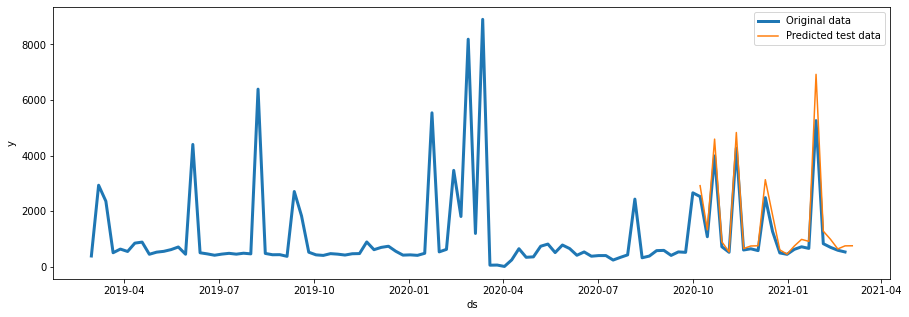

In [262]:
#@title Plotting the forecasted values against actual values
# Plotting the prophet model forecast
rcParams['figure.figsize'] = 15, 5
sns.lineplot(df_prophet_m['ds'],df_prophet_m['y'], label ='Original data',linewidth = 3)
sns.lineplot(forecast_prophet_m['ds'],forecast_prophet_m['yhat'], label ='Predicted test data')

Blue line goes through the predicted values. Black dots are the actual values over the time spam. Light blue area is the upper and lower limit(confidence) of the forecast.

I checked for some of the items, the root mean square error is quite large. I manually checked those articles with different models but gave worst results. 
For example in case of 500g Speghetti , prophet model gave the rmse around 500. However, other 2 model have around 1000 and 2000. 

Upon further diagnosis of the dataset, it is found that the prediction accuracy vary because it is for just 2 years. Between the time period of oct 2019 to Feb-2020 there was average sale however in test data the sale was very high during these months. Regardless of that, the model predicted high sales as can be seen in graph above.

Another thing to notice is that even though the rmse is large, the predicted data is very close to the last week sales data . For example Prophet model predicted 713 items would be sold and the last week around 532 items are sold. 

#### Evaluation

In [264]:
df_cv_m = cross_validation(model_prophet_m,initial='465 days',period='7 days', horizon='14 days'  )

INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


In [265]:
# checking the last 5 values of the pedicted values(yhat) against the actual values(y)
df_cv_m.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
25,2020-09-17,447.912737,243.525087,630.859822,534.0,2020-09-03
26,2020-09-17,454.008125,250.769991,640.738514,534.0,2020-09-10
27,2020-09-24,572.478015,390.783762,774.029547,518.0,2020-09-10
28,2020-09-24,579.639120,406.449734,757.758096,518.0,2020-09-17
29,2020-10-01,3645.539056,3449.955724,3814.392999,2660.0,2020-09-17


In [266]:
# Checking the performance of the model
from fbprophet.diagnostics import performance_metrics
df_p_m = performance_metrics(df_cv_m)
df_p_m

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,35356.128152,188.032253,106.862565,0.174237,0.159394,0.933333
1,14 days,104849.004264,323.803960,176.090045,0.207005,0.181618,0.866667


In [267]:
#@title Calculate RMSE performance metrics for training data
error = df_p_m['rmse'].iloc[-1]
print(f'The root mean square error for the dataset is : {error} ')

The root mean square error for the dataset is : 323.803959617155 


In [268]:
#@title Calculate RMSE performance metrics for test data 
### Calculate RMSE performance metrics for test data 


print(f'Root mean square error of test dataset is : {math.sqrt(mean_squared_error(test_prophet.y,forecast_prophet_m.yhat))}')

Root mean square error of test dataset is : 479.3267992219474


In [340]:
#@title Observations
df_prophet_m = df_date[df_date.art_name == '500g Spaghetti']
print(f'Maximmum amount of item sold in 1 week is : {df_prophet_m.sold_qty_units.max()}')
print(f'Mean of the item sold in 1 week is : {df_prophet_m.sold_qty_units.mean()}')


Maximmum amount of item sold in 1 week is : 8902.0
Mean of the item sold in 1 week is : 1130.1714285714286


In [269]:
#@title Next week prediction
sold_item = forecast_prophet_m['yhat'].iloc[-1]
print(f'It is predicted that next week {round(sold_item)} items would be sold')
print(f'Total quantity sold for this item in last three weeks are {df_prophet_m.y[-3:].values}')

It is predicted that next week 755 items would be sold
Total quantity sold for this item in last three weeks are [698. 594. 532.]




---



## <Center>Crosscheck-prophet model for 500g Speciality Pasta because of high rmse

In [344]:
df_prophet_m = df_date[df_date.art_name == '500g Speciality Pasta']


In [345]:
# Preparing dataset for the profet model as it takes input value in particul convention
df_prophet_m = df_prophet_m.reset_index()[['date','store_count','sold_qty_units','week','month','total_cust_count']].rename({'date':'ds','sold_qty_units':'y','store_count':'store_count','week':'week','month':'month','total_cust_count':'total_cust_count'},axis='columns')
# Dividing the data into train and test set so that when prediction, it need values of other columns kuje week, month, store count etc, so we can add those information
#from the test dataset
start = '2019-02-28'
end =  '2020-10-01'
train_prophet = df_prophet_m[(df_prophet_m['ds']>=start) & (df_prophet_m['ds']<=end)]
test_prophet = df_prophet_m[(df_prophet_m['ds']>end)]
# Initializing 
model_prophet_m = Prophet()
# By defaul, prophet just takes 2 columns. As it is an additive linear model by default. I am adding these columns as additional regressors
model_prophet_m.add_regressor('store_count',standardize='auto',mode='multiplicative')
model_prophet_m.add_regressor('total_cust_count',standardize='auto',mode='multiplicative')
model_prophet_m.add_regressor('week',standardize='auto')
model_prophet_m.add_regressor('month',standardize='auto')
model_prophet_m.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [346]:
# adding values of the last week for future forecast
def get_lastinput(): 
  ls = [] 
  future_dates_m = model_prophet_m.make_future_dataframe(periods=(len(test_prophet)+1),freq='W-THU')
  ls.append(future_dates_m['ds'].iloc[-1])
  ls.append(test_prophet['store_count'].iloc[-1])
  ls.append(test_prophet['y'].iloc[-1])
  ls.append(week_number_of_month(future_dates_m['ds'].iloc[-1]))
  ls.append(future_dates_m['ds'].iloc[-1].month)
  ls.append(test_prophet['total_cust_count'].iloc[-1])

  return ls
  
df_length = len(test_prophet)
test_prophet.loc[df_length] = get_lastinput()
test_prophet = test_prophet.reset_index(drop=True)
test_prophet_m = test_prophet.drop(columns='y')
forecast_prophet_m = model_prophet_m.predict(test_prophet_m)

Blue line goes through the predicted values. Black dots are the actual values over the time spam. Light blue area is the upper and lower limit(confidence) of the forecast.

#### Evaluation

In [348]:
df_cv_m = cross_validation(model_prophet_m,initial='465 days',period='7 days', horizon='14 days'  )

INFO:fbprophet:Making 15 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-09-17 00:00:00


In [349]:
# checking the last 5 values of the pedicted values(yhat) against the actual values(y)
df_cv_m.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
25,2020-09-17,261.427421,209.331516,315.661686,277.0,2020-09-03
26,2020-09-17,260.779371,207.299214,318.019670,277.0,2020-09-10
27,2020-09-24,284.120547,229.036595,339.964144,294.0,2020-09-10
28,2020-09-24,286.388609,232.349615,336.840565,294.0,2020-09-17
29,2020-10-01,1527.276812,1473.505425,1584.588813,1386.0,2020-09-17


In [350]:
# Checking the performance of the model
from fbprophet.diagnostics import performance_metrics
df_p_m = performance_metrics(df_cv_m)
df_p_m

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,2205.915087,46.967170,35.688735,0.071478,0.054139,0.800000
1,14 days,4035.930518,63.528974,47.433215,0.080304,0.060288,0.733333


In [351]:
#@title Calculate RMSE performance metrics for training data
error = df_p_m['rmse'].iloc[-1]
print(f'The root mean square error for the dataset is : {error} ')

The root mean square error for the dataset is : 63.528973848853354 


In [352]:
#@title Calculate RMSE performance metrics for test data 
### Calculate RMSE performance metrics for test data 


print(f'Root mean square error of test dataset is : {math.sqrt(mean_squared_error(test_prophet.y,forecast_prophet_m.yhat))}')

Root mean square error of test dataset is : 171.1041327562688


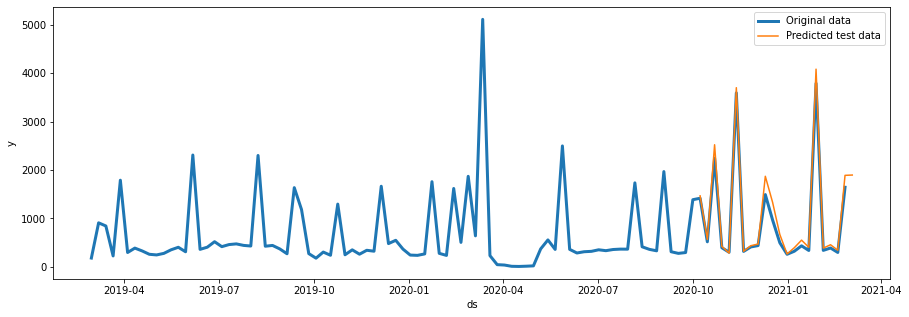

In [347]:
#@title Plotting the forecasted values against actual values
# Plotting the prophet model forecast
rcParams['figure.figsize'] = 15, 5
sns.lineplot(df_prophet_m['ds'],df_prophet_m['y'], label ='Original data',linewidth = 3)
sns.lineplot(forecast_prophet_m['ds'],forecast_prophet_m['yhat'], label ='Predicted test data')

In [353]:
#@title Observations
df_prophet_m = df_date[df_date.art_name == '500g Speciality Pasta']
print(f'Maximmum amount of item sold in 1 week is : {df_prophet_m.sold_qty_units.max()}')
print(f'Mean of the item sold in 1 week is : {df_prophet_m.sold_qty_units.mean()}')


Maximmum amount of item sold in 1 week is : 5112.0
Mean of the item sold in 1 week is : 699.9619047619047


As we can see from the above graph the model performs faily well. It was able to predict the spike in sales . However due to high variance between the mean and maximum amound sold, the value of rmse grew more.

In [354]:
#@title Next week prediction
sold_item = forecast_prophet_m['yhat'].iloc[-1]
print(f'It is predicted that next week {round(sold_item)} items would be sold')
print(f'Total quantity sold for this item in last three weeks are {df_prophet_m.sold_qty_units[-3:].values}')

It is predicted that next week 1895 items would be sold
Total quantity sold for this item in last three weeks are [ 388.  296. 1643.]




---

